In [2]:
import numpy as np
import sys
import cv2
import os
import matplotlib.pyplot as plt

sys.path.append('FBA_Matting')
from demo import  pred
from networks.models import build_model

In [4]:
class Args:
  encoder = 'resnet50_GN_WS'
  decoder = 'fba_decoder'
  weights = 'FBA.pth'
args=Args()
try:
    model = build_model(args)
except:
    !gdown  https://drive.google.com/uc?id=1T_oiKDE_biWf2kqexMEN7ObWqtXAzbB1
    model = build_model(args)

modifying input layer to accept 11 channels


In [8]:
sys.path.append('HairMapper')

from HairMapper.classifier.src.feature_extractor.hair_mask_extractor import get_hair_mask, get_parsingNet

parsingNet = get_parsingNet(save_pth='HairMapper/ckpts/face_parsing.pth')

load face_parsing model from:  HairMapper/ckpts/face_parsing.pth


In [9]:
input_img_path = 'dataset/img/test/CM_1004.png'
file_name_with_extension = os.path.basename(input_img_path)
file_name, _ = os.path.splitext(file_name_with_extension)
img_bgr = cv2.imread(input_img_path)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

In [10]:
trimap_result_path = 'dataset/trimap/test/'

binary_mask = get_hair_mask(img_path=img_rgb, net=parsingNet, include_hat=True, include_ear=False, dilate_kernel=10)

# Dilate the mask
kernel = np.ones((20,20), np.uint8)
dilated_mask = cv2.dilate(binary_mask, kernel, iterations=1)
eroded_mask = cv2.erode(binary_mask, kernel, iterations=1)

# Define trimap values for the unknown, hair, and background regions
TRIMAP_UNKNOWN = 128
TRIMAP_HAIR = 255
TRIMAP_BACKGROUND = 0

# Initialize trimap with unknown region
trimap = np.full(binary_mask.shape, TRIMAP_UNKNOWN, dtype=np.uint8)

trimap[eroded_mask == TRIMAP_HAIR] = TRIMAP_HAIR  
trimap[dilated_mask == TRIMAP_BACKGROUND] = TRIMAP_BACKGROUND  

trimap_path = os.path.join(trimap_result_path, file_name+'.png')
os.makedirs(os.path.dirname(trimap_path), exist_ok=True)
cv2.imwrite(trimap_path,trimap)

True

In [11]:
def read_image(name):
    return (cv2.imread(name) / 255.0)[:, :, ::-1]


def read_trimap(name):
    trimap_im = cv2.imread(name, 0) / 255.0
    h, w = trimap_im.shape
    trimap = np.zeros((h, w, 2))
    trimap[trimap_im == 1, 1] = 1
    trimap[trimap_im == 0, 0] = 1
    return trimap

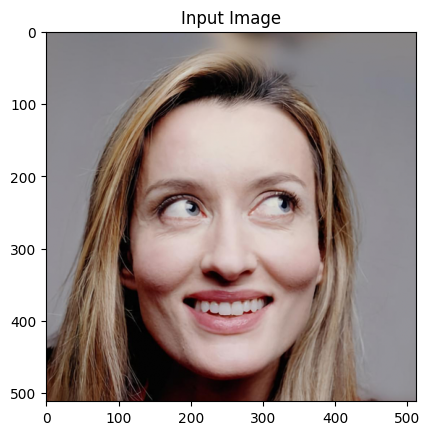

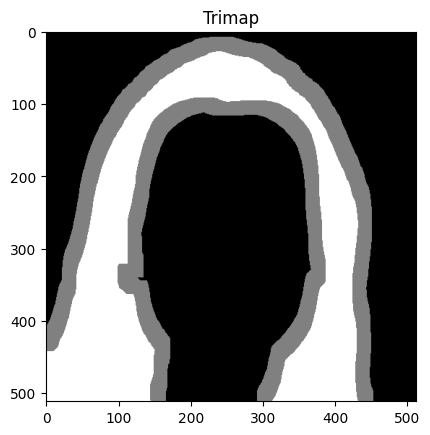

In [12]:
image = read_image(input_img_path)
trimap = read_trimap(trimap_path)

plt.title('Input Image')
plt.imshow(image)
plt.show()

# transform two channel trimap back to single channel
trimap_im =  trimap[:,:,1] + (1-np.sum(trimap,-1))/2
plt.title('Trimap')
plt.imshow(trimap_im, cmap='gray', vmin=0, vmax=1)
plt.show()

In [13]:
model.cuda()
fg, bg, alpha = pred(image, trimap, model)

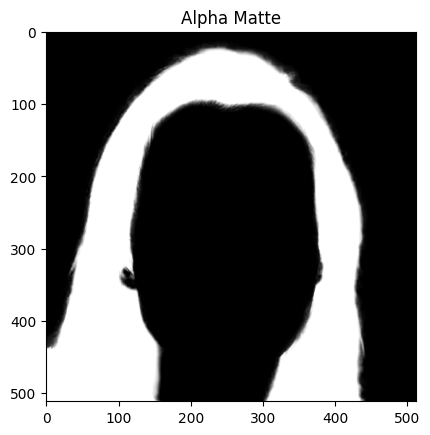

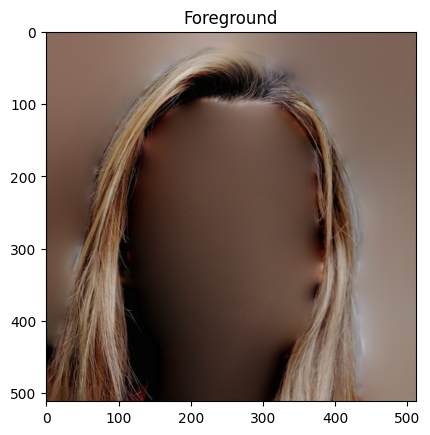

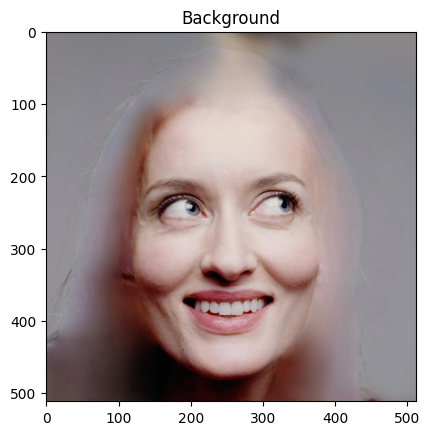

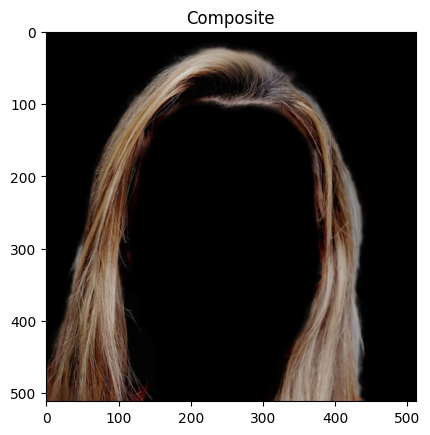

In [14]:
plt.title('Alpha Matte')
plt.imshow(alpha, cmap='gray', vmin=0, vmax=1)
plt.show()
plt.title('Foreground')
plt.imshow(fg)
plt.show()
plt.title('Background')
plt.imshow(bg)
plt.show()
plt.title('Composite')
plt.imshow(fg*alpha[:,:,None])
plt.show()